In [4]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2S  # Consider using EfficientNetV2M or L for higher capacity
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import numpy as np
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

data_dir = 'C:/Users/Public/5th/NeuralNetworks/TeamProject/chest_xray'
train_dir = f'{data_dir}/train'
test_dir = f'{data_dir}/test'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(260, 260),
    batch_size=32,
    class_mode='categorical',
    subset='training')


validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(260, 260),
    batch_size=32,
    class_mode='categorical',
    subset='validation')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(260, 260),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False)

Found 4710 images belonging to 2 classes.
Found 522 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [5]:
base_model = EfficientNetV2S(weights='imagenet', include_top=False, input_shape=(260, 260, 3))
base_model.trainable = False

x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation='relu')(x)
predictions = layers.Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping1 = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)

early_stopping2 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True)

In [6]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping1])

Epoch 1/30


147/147 [==============================] - 345s 2s/step - loss: 0.3793 - accuracy: 0.8102 - val_loss: 0.3593 - val_accuracy: 0.8145
Epoch 2/30
147/147 [==============================] - 413s 3s/step - loss: 0.3382 - accuracy: 0.8399 - val_loss: 0.3044 - val_accuracy: 0.8379
Epoch 3/30
147/147 [==============================] - 422s 3s/step - loss: 0.3179 - accuracy: 0.8476 - val_loss: 0.3262 - val_accuracy: 0.8379
Epoch 4/30
147/147 [==============================] - 401s 3s/step - loss: 0.3131 - accuracy: 0.8557 - val_loss: 0.3618 - val_accuracy: 0.8164
Epoch 5/30
147/147 [==============================] - 414s 3s/step - loss: 0.3099 - accuracy: 0.8566 - val_loss: 0.2847 - val_accuracy: 0.8496
Epoch 6/30
147/147 [==============================] - 408s 3s/step - loss: 0.3023 - accuracy: 0.8570 - val_loss: 0.3075 - val_accuracy: 0.8477
Epoch 7/30
147/147 [==============================] - 391s 3s/step - loss: 0.3080 - accuracy: 0.8563 - val_loss: 0.3177 - val_accuracy: 0.83

In [7]:
def plot_history(history, title_suffix=''):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'Model accuracy {title_suffix}')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'Model loss {title_suffix}')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

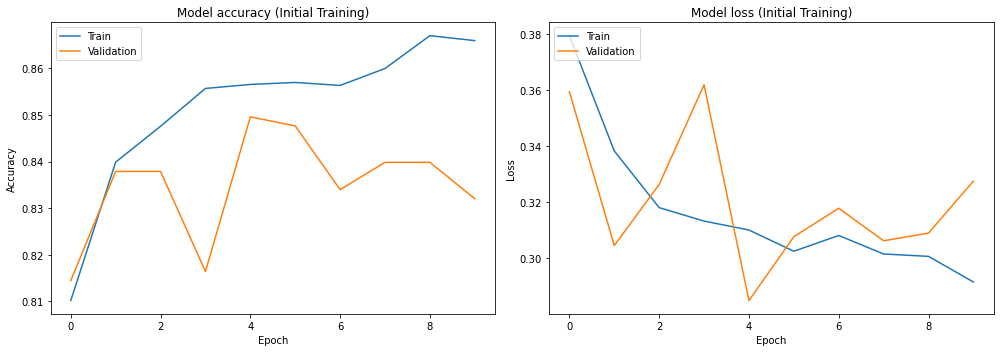

In [8]:
plot_history(history, title_suffix='(Initial Training)')

In [9]:
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [10]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [11]:
history_fine = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    callbacks=[early_stopping2])

Epoch 1/30
147/147 [==============================] - 796s 5s/step - loss: 0.5687 - accuracy: 0.7805 - val_loss: 0.5379 - val_accuracy: 0.8027
Epoch 2/30
147/147 [==============================] - 733s 5s/step - loss: 0.4161 - accuracy: 0.8369 - val_loss: 0.4276 - val_accuracy: 0.8203
Epoch 3/30
147/147 [==============================] - 776s 5s/step - loss: 0.3641 - accuracy: 0.8465 - val_loss: 0.3730 - val_accuracy: 0.8555
Epoch 4/30
147/147 [==============================] - 842s 6s/step - loss: 0.3202 - accuracy: 0.8604 - val_loss: 0.3252 - val_accuracy: 0.8633
Epoch 5/30
147/147 [==============================] - 847s 6s/step - loss: 0.3357 - accuracy: 0.8568 - val_loss: 0.3257 - val_accuracy: 0.8555
Epoch 6/30
147/147 [==============================] - 888s 6s/step - loss: 0.3256 - accuracy: 0.8540 - val_loss: 0.3232 - val_accuracy: 0.8457
Epoch 7/30
147/147 [==============================] - 887s 6s/step - loss: 0.2731 - accuracy: 0.8788 - val_loss: 0.2906 - val_accuracy: 0.8555

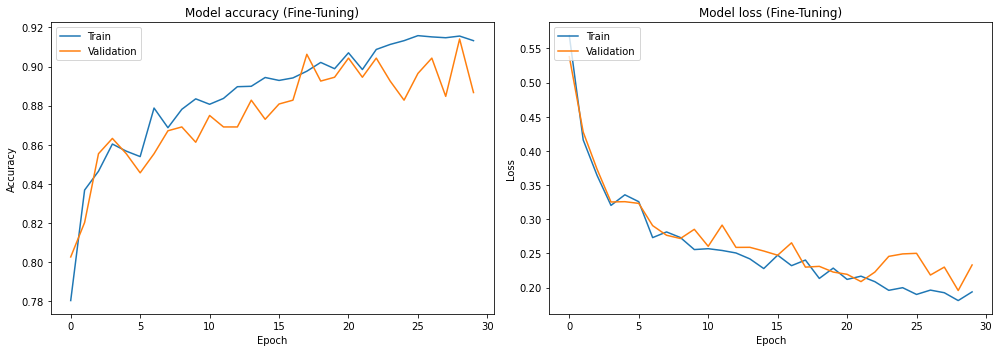

In [12]:
plot_history(history_fine, title_suffix='(Fine-Tuning)')

In [13]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')

20/20 [==============================] - 36s 2s/step - loss: 0.4187 - accuracy: 0.8574
Test Loss: 0.4187110364437103, Test Accuracy: 0.8573718070983887


20/20 [==============================] - 43s 2s/step


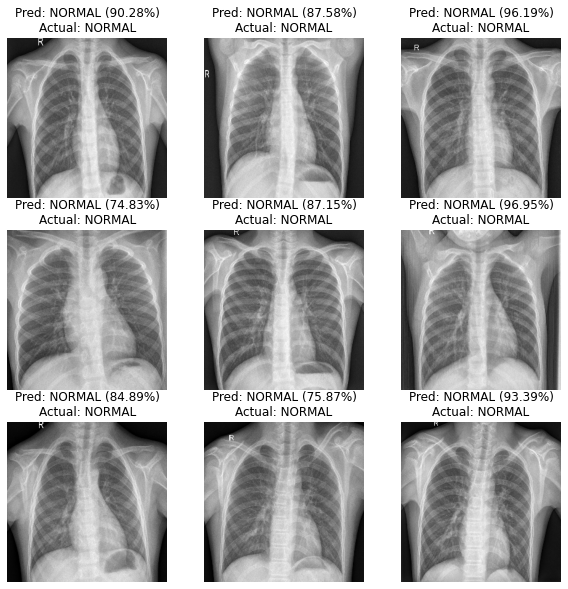

In [14]:
predictions = model.predict(test_generator, steps=len(test_generator))
test_generator.reset()
images, labels = next(test_generator)


label_map = dict((v, k) for k, v in test_generator.class_indices.items())

num_images_to_display = 9

plt.figure(figsize=(10, 10))

for i in range(num_images_to_display):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])

    predicted_label = label_map[np.argmax(predictions[i])]

    actual_label = label_map[np.argmax(labels[i])]
    plt.title(f"Pred: {predicted_label} ({np.max(predictions[i]) * 100:.2f}%)\nActual: {actual_label}")
    plt.axis("off")
plt.show()

20/20 [==============================] - 37s 2s/step
              precision    recall  f1-score   support

      NORMAL       0.83      0.79      0.81       234
   PNEUMONIA       0.88      0.90      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.84      0.85       624
weighted avg       0.86      0.86      0.86       624

Confusion Matrix:
[[184  50]
 [ 39 351]]
ROC-AUC Score: 0.9047775586237125


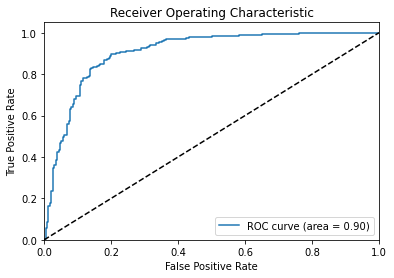

In [15]:
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())   

report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

cm = confusion_matrix(true_classes, predicted_classes)
print("Confusion Matrix:")
print(cm)

roc_auc = roc_auc_score(true_classes, predictions[:, 1])
print("ROC-AUC Score:", roc_auc)

fpr, tpr, thresholds = roc_curve(true_classes, predictions[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
